Import data

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving sales.csv to sales (3).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['sales.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.utils import np_utils
# Importing required packages

A short EDA

In [ ]:
print (df.head())
print (df.describe())
print (df.info())
# General impression of the data


         date  barcode     buy      sale   stock  price
0  01/01/2017      1.0     NaN   316.669 -318.46   5.90
1  02/01/2017      1.0     NaN   357.692 -677.43   5.90
2  03/01/2017      1.0   609.0   800.131 -870.30   4.33
3  04/01/2017      1.0  1458.0   917.331 -330.65   5.90
4  05/01/2017      1.0  1335.0  1095.586  -92.42   5.90
           barcode           buy         sale         stock        price
count  4597.000000   2288.000000  4142.000000   4596.000000  4142.000000
mean      1.975419    825.887128   494.700095   -153.344186     6.002549
std       0.821574    841.719785   456.066079  14115.290532     1.471375
min       1.000000      0.000000     1.000000 -62687.040000     1.900000
25%       1.000000    320.000000    11.000000   -570.717500     5.080000
50%       2.000000    720.000000   447.000000     92.000000     5.900000
75%       3.000000   1107.500000   800.155000    868.535000     6.900000
max       3.000000  14490.490000  2193.690000  82551.940000     9.900000
<class 

Distributions of the 3 barcodes data subsets

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



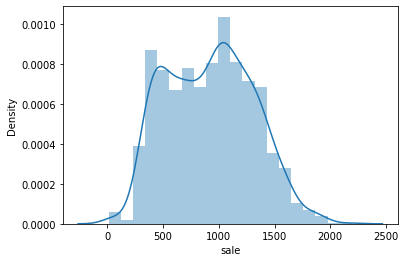

In [ ]:
sns.distplot(df.sale[df.barcode==1])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



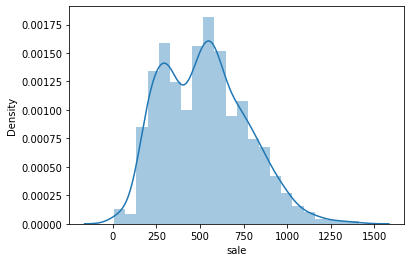

In [ ]:
sns.distplot(df.sale[df.barcode==2])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



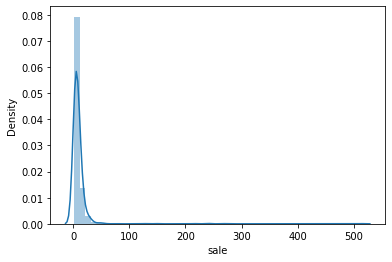

In [ ]:
sns.distplot(df.sale[df.barcode==3])

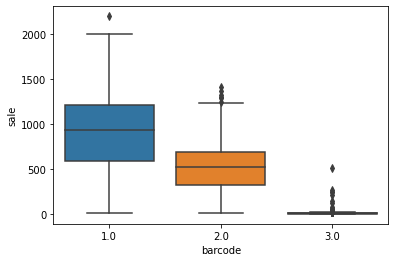

In [ ]:
sns.boxplot(x="barcode", y="sale", data=df)
# The presence of outliers was detected

In [ ]:
def sales_duration(data):  # Checking for duration of data collection
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(df)

1801 days
4.934246575342466 years


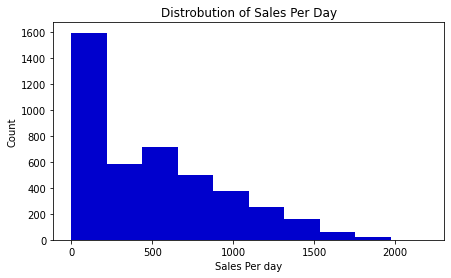

In [ ]:
def sales_per_day(): # Checking where the bulk of the data lies
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(df.sale, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distrobution of Sales Per Day")
    
sales_per_day()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



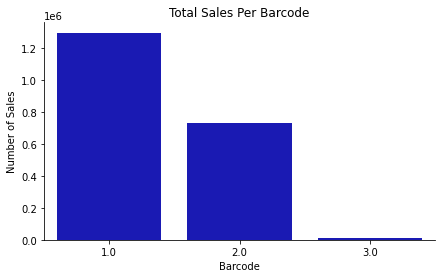

In [ ]:
def sales_per_barcode():  # The barcodes data subsets are not equal in size
    by_store = df.groupby('barcode')['sale'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(by_store.barcode, by_store.sale, color='mediumblue')
    
    ax.set(xlabel = "Barcode",
           ylabel = "Number of Sales",
           title = "Total Sales Per Barcode")
    
    sns.despine()
    
sales_per_barcode()

Cleaning the data of outliers in barcodes 2 & 3

In [ ]:
Q1 = df.sale[df.barcode==3].quantile(0.25)
Q3 = df.sale[df.barcode==3].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df.sale[df.barcode==3] >= Q1 - 1.5 * IQR) & (df.sale[df.barcode==3] <= Q3 + 1.5 *IQR)
filt = df.sale[(df.barcode==3) & ~filter].index.values
print (len(df.sale[(df.barcode==3) & ~filter]), len(df.sale[df.barcode==3]))
print (Q1, Q3)
print (Q3 + 1.5 *IQR)
df=df.drop(index=filt)

245 1496
3.0 10.0
20.5


In [ ]:
Q1 = df.sale[df.barcode==2].quantile(0.25)
Q3 = df.sale[df.barcode==2].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df.sale[df.barcode==2] >= Q1 - 1.5 * IQR) & (df.sale[df.barcode==2] <= Q3 + 1.5 *IQR)
filt = df.sale[(df.barcode==2) & ~filter].index.values
df=df.drop(index=filt)

In [ ]:
print (df[["sale", "barcode"]].groupby("barcode").quantile(0.95))
print (df[["sale", "barcode"]].groupby("barcode").quantile(1.00))

              sale
barcode           
1.0      1555.7335
2.0       938.4000
3.0        15.0000
            sale
barcode         
1.0      2193.69
2.0      1229.00
3.0        20.00


In [ ]:
df.drop([374], axis=0, inplace=True) #Dropping completely blank row


In [ ]:
df[['buy', 'sale', 'stock']] = df[['buy', 'sale', 'stock']].fillna(value=0)
df[['barcode']] = df[['barcode']].fillna(method="ffill")
df[['price']] = df[['price']].fillna(value=df.mean())
# Filling missing values

Preparation of the data - choosing of the last 10 days as a base for prediction

In [ ]:
df[["sale"]]

,sale
0,316.669
1,357.692
2,800.131
3,917.331
4,1095.586
...,...
4594,3.000
4595,1.000
4596,9.000
4597,9.000


In [ ]:
#create dataframe for transformation from time series to supervised
def prepare_for_lstm(data):
  #adding lags
  for i in range(1,11):
      col = 'prev_' + str(i)
      data[col] = data['sale'].shift(i) #drop null values
      #drop null values
  data = data.dropna()
  return data

In [ ]:
df_barcode1 = prepare_for_lstm(df[["sale"]][df.barcode==1])
df_barcode2 = prepare_for_lstm(df[["sale"]][df.barcode==2])
df_barcode3 = prepare_for_lstm(df[["sale"]][df.barcode==3])

df_barcode3.head(10)

,sale,prev_1,prev_2,prev_3,prev_4,prev_5,prev_6,prev_7,prev_8,prev_9,prev_10
3118,4.0,8.0,6.0,1.0,6.0,5.0,10.0,2.0,4.0,1.0,2.0
3119,6.0,4.0,8.0,6.0,1.0,6.0,5.0,10.0,2.0,4.0,1.0
3121,5.0,6.0,4.0,8.0,6.0,1.0,6.0,5.0,10.0,2.0,4.0
3122,1.0,5.0,6.0,4.0,8.0,6.0,1.0,6.0,5.0,10.0,2.0
3124,2.0,1.0,5.0,6.0,4.0,8.0,6.0,1.0,6.0,5.0,10.0
3125,10.0,2.0,1.0,5.0,6.0,4.0,8.0,6.0,1.0,6.0,5.0
3126,2.0,10.0,2.0,1.0,5.0,6.0,4.0,8.0,6.0,1.0,6.0
3130,4.0,2.0,10.0,2.0,1.0,5.0,6.0,4.0,8.0,6.0,1.0
3131,1.0,4.0,2.0,10.0,2.0,1.0,5.0,6.0,4.0,8.0,6.0
3132,3.0,1.0,4.0,2.0,10.0,2.0,1.0,5.0,6.0,4.0,8.0


In [ ]:
df[df.date=="2020-03-08"]

,date,barcode,buy,sale,stock,price
1232,2020-03-08,1.0,727.0,550.475,908.41,4.9
2777,2020-03-08,2.0,480.0,352.000,-2707.00,5.9
4274,2020-03-08,3.0,0.0,4.000,66.00,7.5


In [ ]:
#split data to train and test. The train set is about 3.5 years (from January 1 2017 to July 31 2020) and test sel will be 11.5 months (from August 1 2020 to July 17 2021)
split_ind = np.where(df.date=="2020-03-08")
train_set1, test_set1 = df_barcode1.loc[0:split_ind[0][0]].values, df_barcode1.loc[split_ind[0][0]:].values
train_set2, test_set2 = df_barcode2.loc[0:split_ind[0][1]].values, df_barcode2.loc[split_ind[0][1]:].values
train_set3, test_set3 = df_barcode3.loc[0:split_ind[0][2]].values, df_barcode3.loc[split_ind[0][2]:].values

Scaling for LSTM - an algorithm that is capable of solving time series tasks

In [ ]:
#import MinMaxScaler and convert data for LSTM model
from sklearn.preprocessing import MinMaxScaler
#apply Min Max Scaler
def scale_data(train_set, test_set):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train_set)
  # reshape training set
  train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
  train_set_scaled = scaler.transform(train_set)# reshape test set
  test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
  test_set_scaled = scaler.transform(test_set)

  # split to x & y
  X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
  X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
  X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
  X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
  return X_train, y_train, X_test, y_test, scaler

X_train1, y_train1, X_test1, y_test1, scaler1 = scale_data(train_set1, test_set1)
X_train2, y_train2, X_test2, y_test2, scaler2 = scale_data(train_set2, test_set2)
X_train3, y_train3, X_test3, y_test3, scaler3 = scale_data(train_set3, test_set3)

In [ ]:
print ("barcode 1: ", X_train1.shape[0], X_test1.shape[0], "barcode 2: ", X_train2.shape[0], X_test2.shape[0], "barcode 3: ", X_train3.shape[0], X_test3.shape[0])

barcode 1:  1221 379 barcode 2:  1038 363 barcode 3:  773 469


Building the model

In [ ]:
def lstm_model(X_train, y_train, X_test, y_test):
  model = Sequential()
  model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])))
  # model.add(Dense(8))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1, shuffle=False)
  return model, history

In [ ]:
def lstm_model3(X_train, y_train, X_test, y_test):
  model = Sequential()
  model.add(LSTM(16, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])))
  model.add(Dense(4))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1, shuffle=False)
  return model, history

In [ ]:
lstm1, history1 = lstm_model(X_train1, y_train1, X_test1, y_test1)
lstm2, history2 = lstm_model(X_train2, y_train2, X_test2, y_test2)
lstm3, history3 = lstm_model3(X_train3, y_train3, X_test3, y_test3)

Epoch 1/20
39/39 [==============================] - 2s 16ms/step - loss: 0.2385 - val_loss: 0.3317
Epoch 2/20
39/39 [==============================] - 0s 3ms/step - loss: 0.2076 - val_loss: 0.2925
Epoch 3/20
39/39 [==============================] - 0s 3ms/step - loss: 0.1908 - val_loss: 0.2696
Epoch 4/20
39/39 [==============================] - 0s 3ms/step - loss: 0.1824 - val_loss: 0.2564
Epoch 5/20
39/39 [==============================] - 0s 3ms/step - loss: 0.1783 - val_loss: 0.2489
Epoch 6/20
39/39 [==============================] - 0s 3ms/step - loss: 0.1762 - val_loss: 0.2445
Epoch 7/20
39/39 [==============================] - 0s 3ms/step - loss: 0.1750 - val_loss: 0.2418
Epoch 8/20
39/39 [==============================] - 0s 3ms/step - loss: 0.1740 - val_loss: 0.2398
Epoch 9/20
39/39 [==============================] - 0s 3ms/step - loss: 0.1733 - val_loss: 0.2384
Epoch 10/20
39/39 [==============================] - 0s 3ms/step - loss: 0.1726 - val_loss: 0.2373
Epoch 11/20
39/39 

Loss summary and representations

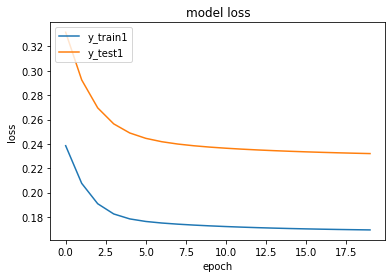

In [ ]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['X_train1', 'X_test1'], loc='upper left')
plt.legend(['y_train1', 'y_test1'], loc='upper left')

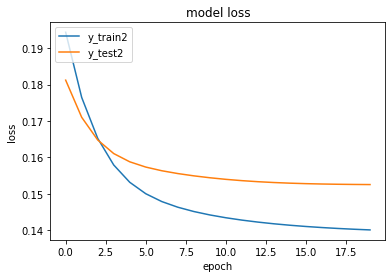

In [ ]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['X_train2', 'X_test2'], loc='upper left')
plt.legend(['y_train2', 'y_test2'], loc='upper left')


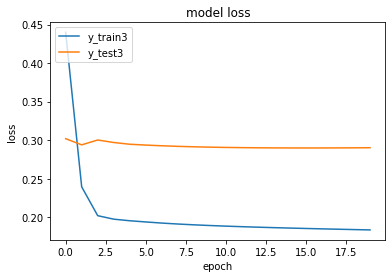

In [ ]:
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['X_train3', 'X_test3'], loc='upper left')
plt.legend(['y_train3', 'y_test3'], loc='upper left')

In [ ]:
y_pred1 = lstm1.predict(X_test1, batch_size=1)
y_pred2 = lstm2.predict(X_test2, batch_size=1)
y_pred3 = lstm3.predict(X_test3, batch_size=1)

In [ ]:
#reshape y_pred
y_pred1 = y_pred1.reshape(y_pred1.shape[0], 1, y_pred1.shape[1])#rebuild test set for inverse transform
pred_test_set1 = []
for index in range(0,len(y_pred1)):
    pred_test_set1.append(np.concatenate([y_pred1[index],X_test1[index]],axis=1))#reshape pred_test_set
pred_test_set1 = np.array(pred_test_set1)
pred_test_set1 = pred_test_set1.reshape(pred_test_set1.shape[0], pred_test_set1.shape[2])

#inverse transform
pred_test1 = scaler1.inverse_transform(pred_test_set1)


In [ ]:
#reshape y_pred
y_pred2 = y_pred2.reshape(y_pred2.shape[0], 1, y_pred2.shape[1])#rebuild test set for inverse transform
pred_test_set2 = []
for index in range(0,len(y_pred2)):
    pred_test_set2.append(np.concatenate([y_pred2[index],X_test2[index]],axis=1))#reshape pred_test_set
pred_test_set2 = np.array(pred_test_set2)
pred_test_set2 = pred_test_set2.reshape(pred_test_set2.shape[0], pred_test_set2.shape[2])

#inverse transform
pred_test2 = scaler2.inverse_transform(pred_test_set2)

In [ ]:
#reshape y_pred
y_pred3 = y_pred3.reshape(y_pred3.shape[0], 1, y_pred3.shape[1])#rebuild test set for inverse transform
pred_test_set3 = []
for index in range(0,len(y_pred3)):
    pred_test_set3.append(np.concatenate([y_pred3[index],X_test3[index]],axis=1))#reshape pred_test_set
pred_test_set3 = np.array(pred_test_set3)
pred_test_set3 = pred_test_set3.reshape(pred_test_set3.shape[0], pred_test_set3.shape[2])

#inverse transform
pred_test3 = scaler3.inverse_transform(pred_test_set3)

How good is our model?

In [ ]:
from scipy.stats import pearsonr
corr1, pval1 = pearsonr(pred_test1[:,0], test_set1[:,0])
corr2, pval2 = pearsonr(pred_test2[:,0], test_set2[:,0])
corr3, pval3 = pearsonr(pred_test3[:,0], test_set3[:,0])
corr=[corr1, corr2, corr3]
pval= [pval1, pval2, pval3]
for p in range(3):
  if pval[p]<0.05:
    print (f"Pearson correlation for model {p+1} is {corr[p]}")

Pearson correlation for model 1 is 0.31187049436700304
Pearson correlation for model 2 is 0.3823171598810107
Pearson correlation for model 3 is 0.20166991957971986


In [ ]:
from scipy.stats import spearmanr
corr1, pval1 = spearmanr(pred_test1[:,0], test_set1[:,0])
corr2, pval2 = spearmanr(pred_test2[:,0], test_set2[:,0])
corr3, pval3 = spearmanr(pred_test3[:,0], test_set3[:,0])
corr=[corr1, corr2, corr3]
pval= [pval1, pval2, pval3]
for p in range(3):
  if pval[p]<0.05:
    print (f"Spearmann correlation for model {p+1} is {corr[p]}")

Pearson correlation for model 1 is 0.3393278722137236
Pearson correlation for model 2 is 0.41770402165559883
Pearson correlation for model 3 is 0.17781969711061577
